# Lab 3: Data Preparation

In the exploration of the loans dataset, we discovered found a few problems in the dataset, which need to be resolved before the dataset is ready for building a predictive model. This exercise is typically referred as either *data preparation*, or *data munging*, or *data wrangling*. 

Here are the problems, we are already aware of:

- There are missing values in some columns. We can estimate these values depending on the number of missing values and the expected importance of the column.

- We observed that ApplicantIncome and LoanAmount seem to contain extreme values at either end. Although they might make intuitive sense, they should be treated appropriately.

### A. Import Python Modules and Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("./loans_train.csv")

### B. Treatment of Missing Values

#### Check for missing values

It is often useful to impute missing values as many ML algorithms do not work with missing data and even if they do, imputing these values often helps to build a more accurate predictive model.

In [4]:
# Find the number of nulls/NaNs in the dataset

df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Note that missing values may not always be nulls/NaNs. For instance, if `Loan_Amount_Term` is 0, does this value make sense or should it be considered missing? That is, we need to understand the dataset well in order to deterime which values are actually missing.

#### Impute/fill missing values in column LoanAmount

There are numerous ways to fill the missing values in column `LoanAmount` – the simplest being replacement by mean, which can be done with the following code:

```pyton
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
```

At the other extreme, we could build an ML model to predict `LoanAmount` on the basis of other columns and then use the model to predict the missing values.

Since, the purpose now is to practice data munging prior applying ML algorithms, we can take an approach, which lies somewhere in between these 2 extremes. We may hypothesise that attributes `Education` and `Self_Employed` combined can give a good estimate of `LoanAmount`.

First, let’s look at the boxplot to see if a trend exists:

Text(0.5,0.98,'')

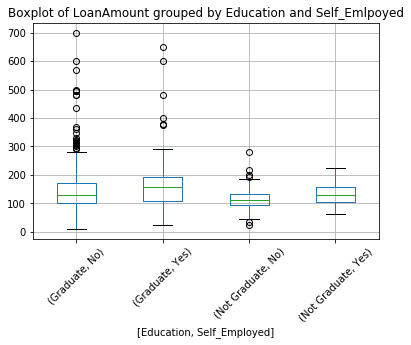

In [5]:
df.boxplot(column='LoanAmount', by=['Education','Self_Employed'], rot=45)

plt.title("Boxplot of LoanAmount grouped by Education and Self_Emlpoyed")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")

We can see some variation in the median of `LoanAmount` for each group and these medians can be used for imputing the missing values in each group. But first, we have to ensure that `Self_Employed` and `Education` do not have missing values.

We know already that `Education` has no missing values, while `Self_Employed` has 32 missing values. Let’s look at the frequency table for `Self_Employed`:

In [6]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Since ~86% of the values are “No”, it is safe to impute the missing values as “No” as there is a high probability of guessing correctly. This can be done using the following code:

In [7]:
df['Self_Employed'].fillna('No', inplace=True)

Next, we create a pivot table, which contains the median values for all four groups.

In [8]:
table = df.pivot_table(values='LoanAmount', 
                       index='Self_Employed', 
                       columns='Education', 
                       aggfunc=np.median)
print(table)

Education      Graduate  Not Graduate
Self_Employed                        
No                130.0         113.0
Yes               157.5         130.0


Finally, we define a function, which returns the values in the pivot table and apply it to fill the missing values of `LoanAmount`.

In [9]:
# Define function to return an element of the pivot table
def get_element(x):
    return table.loc[x['Self_Employed'], x['Education']]

# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(get_element, axis=1), inplace=True)

In [10]:
# Verify there are no missing values in column LoanAmount

df['LoanAmount'].describe()

count    614.000000
mean     145.764658
std       84.145700
min        9.000000
25%      100.250000
50%      128.000000
75%      164.750000
max      700.000000
Name: LoanAmount, dtype: float64

Similarly, the missing values for Gender, Married, Dependents, Loan_Amount_Term and Credit_History can be imputed as well.

### C. Treatment of Extreme Values/Outliers and Creation of Derived Features

In the previous lab exercise, we observed that `LoanAmount` and `ApplicantIncome` contain some extreme values. Let's take a look at their histograms again.

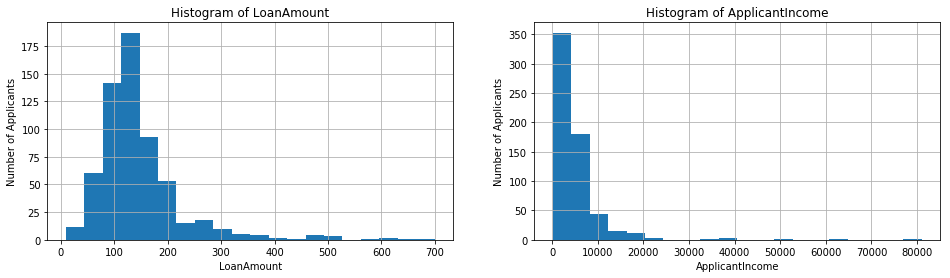

In [11]:
# Create figure with two subplots
fig = plt.figure(figsize=(16,4))

# Plot LoanAmount
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of LoanAmount")
ax1.set_xlabel('LoanAmount')
ax1.set_ylabel('Number of Applicants')
df['LoanAmount'].hist(bins=20)

# Plot LoanAmount_log
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Histogram of ApplicantIncome")
ax2.set_xlabel('ApplicantIncome')
ax2.set_ylabel('Number of Applicants')
df['ApplicantIncome'].hist(bins=20) 

Let’s analyse LoanAmount first. Since the extreme values are practically possible, i.e. some people might apply for high-value loans, instead of ignoring the data rows with extreme LoanAmount values, we can use a log transformation to decrease any negative impact they may have later on when applying a ML algorithm to build a predictive model.

In [12]:
# Use a log transformation to decrease the impact of extreme values in column LoanAmount
df['LoanAmount_log'] = np.log(df['LoanAmount'])

Regarding `ApplicantIncome`, one intuition can be that some applicants have a low income but a co-applicant with a high income. So, it might be a good idea to combine both incomes as total income and take a log transformation of it.

In [13]:
# Create TotalIncome column and apply a log transformation
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])

Let's plot again histograms for LoanAmount and ApplicantIncome as well as histograms for the two new attributes we created.

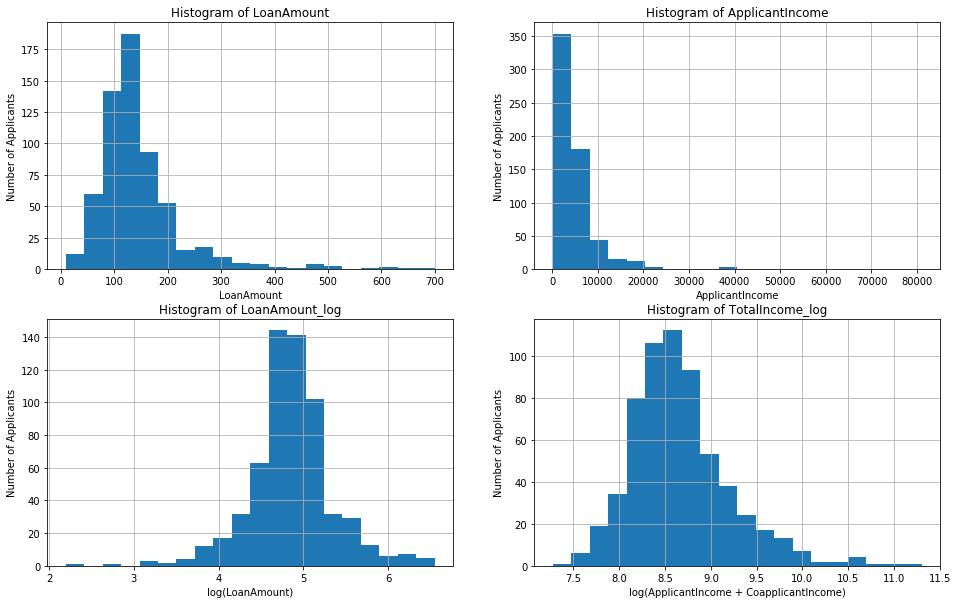

In [17]:
# Create figure with four subplots
fig = plt.figure(figsize=(16,10))

# Plot LoanAmount
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("Histogram of LoanAmount")
ax1.set_xlabel('LoanAmount')
ax1.set_ylabel('Number of Applicants')
df['LoanAmount'].hist(bins=20)

# Plot LoanAmount_log
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("Histogram of ApplicantIncome")
ax2.set_xlabel('ApplicantIncome')
ax2.set_ylabel('Number of Applicants')
df['ApplicantIncome'].hist(bins=20)

# Plot LoanAmount_log
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("Histogram of LoanAmount_log")
ax3.set_xlabel('log(LoanAmount)')
ax3.set_ylabel('Number of Applicants')
df['LoanAmount_log'].hist(bins=20)

# Plot LoanAmount_log
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("Histogram of TotalIncome_log")
ax4.set_xlabel('log(ApplicantIncome + CoapplicantIncome)')
ax4.set_ylabel('Number of Applicants')
df['TotalIncome_log'].hist(bins=20) 

The histograms show that both new features have distribution closer to normal than the original features `LoanAmount` and `ApplicantIncome`.

Similar to `TotalIncome_log`, it is possible to derive other additional information from the data. For example, a feature for `LoanAmount/TotalIncome` can be created, which might make sense as it gives an idea of how well the applicant is suited to pay back the loan.